In [1]:
from collections import defaultdict
import copy
import matplotlib.pyplot as plt
from circuit.parser import get_circuit_duration
from plot.plot import plot_duration_fidelity, plot_top_ratio, find_error_path
import random
import numpy as np

from circuit import gen_random_circuits, label_ground_truth_fidelity
from upstream import RandomwalkModel
from downstream import FidelityModel
from simulator import NoiseSimulator
from utils.backend import devide_chip, gen_grid_topology, get_grid_neighbor_info, Backend, topology_to_coupling_map
from utils.backend import default_basis_single_gates, default_basis_two_gates
import pickle

In [2]:
with open(f"upstream_model_18_0_2500.pkl","rb")as f:
    upstream_model = pickle.load(f)

FileNotFoundError: [Errno 2] No such file or directory: 'upstream_model_18_0_2500.pkl'

In [3]:
with open(f"error_params_predicts_execute_18bits_train_0_2500_bias.pkl","rb")as f:
# with open(f"error_params_predicts_execute_18bits_train_0_2500.pkl","rb")as f:
    downstream_model, predicts, reals, durations = pickle.load(f)
error_params = downstream_model.error_params
print(error_params)
error_params = downstream_model.error_params['gate_params']

FileNotFoundError: [Errno 2] No such file or directory: 'error_params_predicts_execute_18bits_train_0_2500_bias.pkl'

In [4]:
# with open(f"error_params_predicts_execute_18bits_train_0_2500_bias.pkl","rb")as f:
# with open(f"error_params_predicts_execute_18bits_train_0_2500.pkl","rb")as f:
#     error_params, predicts, reals, durations = pickle.load(f)
# error_params = downstream_model.error_params

In [5]:
downstream_model.error_params

{'circuit_bias': Array([-74.10199], dtype=float32),
 'gate_params': Array([[5.5104822e-02, 7.0192432e-03, 1.3777038e+00, ..., 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00],
        [6.6061602e+00, 7.6305266e-03, 1.0322740e+00, ..., 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00],
        [5.1740998e-01, 7.6044691e-03, 2.4176327e+01, ..., 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00],
        ...,
        [1.5225390e+01, 4.2706898e+01, 2.4880020e+01, ..., 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00],
        [9.3495053e-01, 1.7051668e+01, 2.6067852e+01, ..., 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00],
        [3.9522758e+01, 3.1537554e+01, 5.0256915e+00, ..., 0.0000000e+00,
         0.0000000e+00, 0.0000000e+00]], dtype=float32)}

In [6]:
# list(downstream_model.error_params['gate_params'])

In [7]:
# error_params = error_params['gate_params']

In [8]:
with open(f"execute_18bit/split_dataset_execute_18bits_train_0_2500.pkl","rb")as f:
    train_dataset, test_dataset = pickle.load(f)

In [9]:
reals = []
for idx, cir in enumerate(test_dataset):
    reals.append(cir['ground_truth_fidelity'])

In [10]:
len(reals)

1500

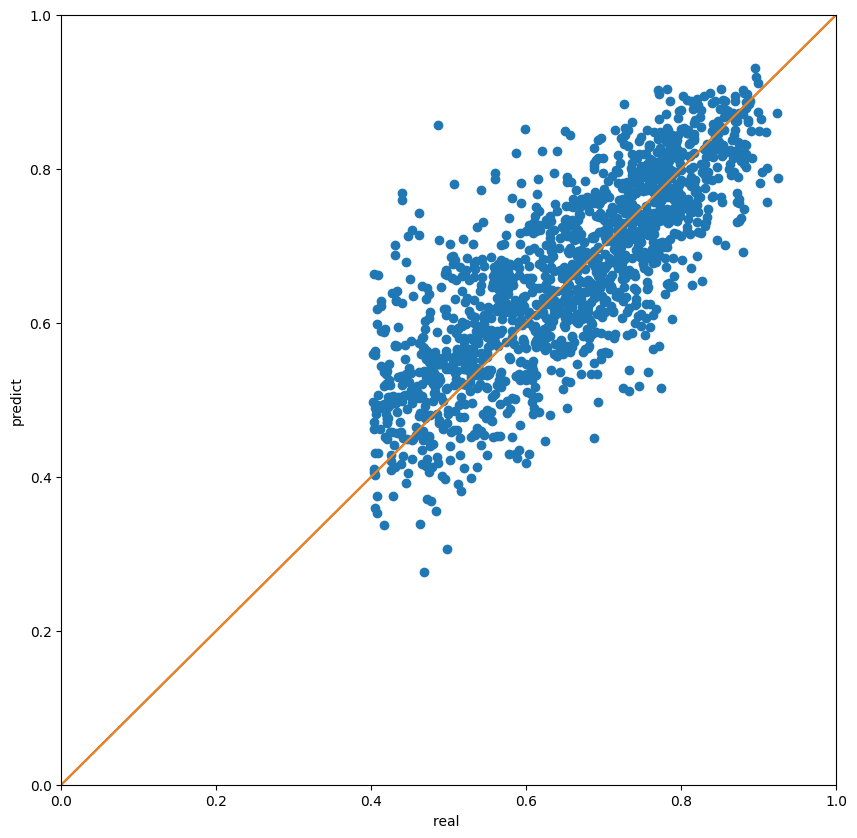

In [11]:
fig, axes = plt.subplots(figsize=(10, 10))  # 创建一个图形对象和一个子图对象
axes.axis([0, 1, 0, 1])
axes.scatter(reals, predicts)
axes.set_xlabel('real ')
axes.set_ylabel('predict')
axes.plot([[0,0],[1,1]])
fig.savefig('18qubit_predict_step1.png')

In [12]:
device_index2device = {}  # 两比特门与但单比特门映射为一维下标
for device in upstream_model.device2path_table.keys():
    device_index = list(
        upstream_model.device2path_table.keys()).index(device)
    device_index2device[device_index] = device

error_params_path_weight = {}  # 训练好的参数对应的path及其权重
error_params_path = {}
for idx, device_error_param in enumerate(error_params):
    device = device_index2device[idx]
    sort = np.argsort(device_error_param)
    sort = sort[::-1]
    device_error_params_path_weight = []
    device_error_params_path = []
    for i in sort:
        if int(i) in upstream_model.device2reverse_path_table[device].keys():
            path = upstream_model.device2reverse_path_table[device][int(i)]
            if isinstance(path, str):
                device_error_params_path_weight.append(
                    (path, float(device_error_param[i])))
                device_error_params_path.append(path)
    error_params_path_weight[device] = device_error_params_path_weight
    error_params_path[device] = device_error_params_path
    
error_params_path_weight

/home/luliqiang/miniconda3/envs/ISCA/lib/python3.9/site-packages/jax/_src/numpy/lax_numpy.py:3485: UserWarning: 'kind' argument to argsort is ignored; only 'stable' sorts are supported.
  warnings.warn("'kind' argument to argsort is ignored; only 'stable' sorts "


{0: [('ry,0-parallel-cz,6,12', 57.87481689453125),
  ('rz,0-parallel-cz,6,12', 57.23011016845703),
  ('rx,0-former-cz,6,12', 54.446598052978516),
  ('rz,0-former-cz,6,12', 49.626434326171875),
  ('ry,0-former-cz,6,12', 33.99186706542969),
  ('ry,0-former-cz,0,6', 31.99451446533203),
  ('ry,0-former-cz,0,1', 30.438182830810547),
  ('rx,0-former-cz,0,6', 28.98582649230957),
  ('rx,0-parallel-cz,1,2', 25.642318725585938),
  ('rz,0-former-cz,0,1', 24.372465133666992),
  ('rz,0-parallel-cz,1,2', 24.106420516967773),
  ('rx,0-parallel-cz,6,7', 20.705629348754883),
  ('ry,0-former-cz,6,7', 19.767547607421875),
  ('ry,0', 19.005661010742188),
  ('rx,0-parallel-cz,6,12', 18.68248176574707),
  ('ry,0-former-cz,1,2', 16.94984245300293),
  ('rx,0-former-rx,0', 16.09337615966797),
  ('rz,0-former-rz,0', 15.705180168151855),
  ('rz,0-former-ry,0', 14.830892562866211),
  ('ry,0-former-rz,0', 14.830642700195312),
  ('rz,0', 11.346132278442383),
  ('ry,0-parallel-ry,6', 8.546550750732422),
  ('ry,0-for

In [ ]:
all_path_error =[]
for device in error_params_path_weight.items():
    error_params_path_weight

In [13]:
from openpyxl import Workbook
wb = Workbook()

for device, device_error_params_path_weight in error_params_path_weight.items():
    ws = wb.create_sheet(str(device))
    for row in device_error_params_path_weight:
        row = list(row)
        ws.append(row)

# Save the file
wb.save("execute_18bits_train_0_2500.xlsx")

In [ ]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(figsize=(10, 10)) 
axes.bar(single_average_error.keys(),single_average_error.values())
axes.set_xticks(list(single_average_error.keys()))
axes.set_ylim(0.99,1)
fig.savefig('18_single.svg')

In [ ]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(figsize=(20, 10))
axes.bar([i for i in range(len(couple_average_error.keys()))],couple_average_error.values())
axes.set_xlabel([key for key in couple_average_error.keys()])
axes.set_ylim(0.95,1)

In [3]:
test_dataset[10].keys()

dict_keys(['qiskit_circuit', 'num_qubits', 'divide_qubits', 'gate_paths', 'path_indexs', 'vecs', 'layer2gates', 'gates', 'gate2layer', 'gate_num', 'map', 'reverse_map', 'duration', 'state_count', 'ground_truth_fidelity', 'circuit_predict'])

In [4]:
# n_gates2n_two_gate2circuits = defaultdict(lambda : defaultdict(list))
# for circuit_info in test_dataset:
#     n_gates = len(circuit_info['gates'])
#     n_two_gates = len([gate for gate in  circuit_info['gates'] if len(gate['qubits']) == 2])
#     n_gates2n_two_gate2circuits[n_gates][n_two_gates].append(circuit_info)

# upstream_model: RandomwalkModel = downstream_model.upstream_model
# for n_gates_list in n_gates2n_two_gate2circuits.values():
#     for n_two_gate_list in n_gates_list.values():
#         if len(n_gates_list) <= 1:
#             continue
        
#         for i1, c1 in enumerate(n_gates_list):
#             p1 = circuit_predict
#             for c2 in n_gates_list[i1+1:]:
                
                
                
                
            
    


IndentationError: expected an indented block (3442793688.py, line 21)

/tmp/ipykernel_1112336/2039205304.py:35: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  fig.colorbar(cm.ScalarMappable( cmap=cmap))


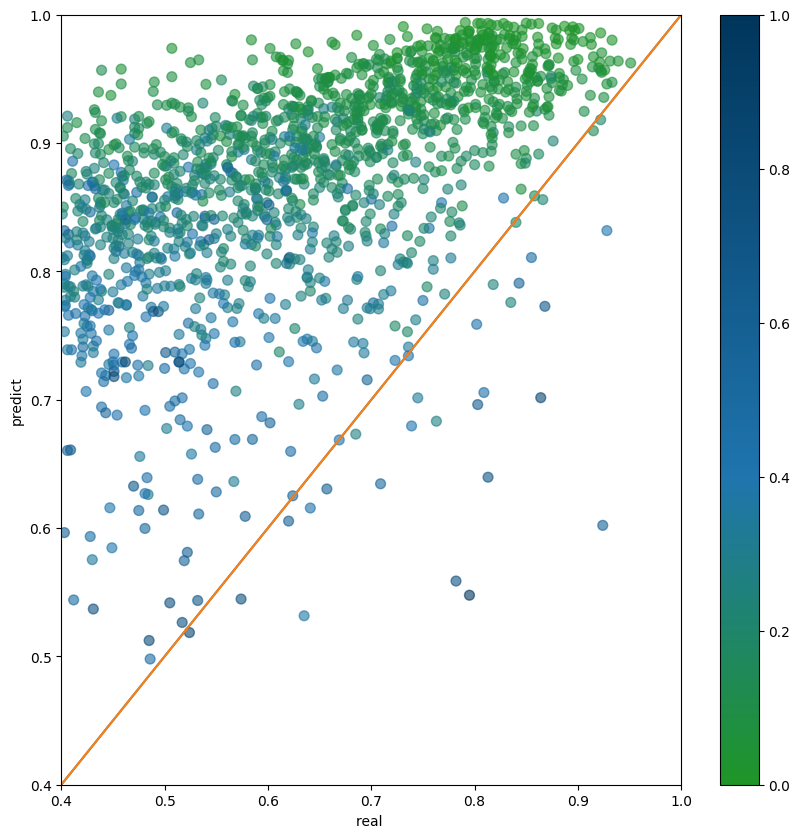

In [19]:
from matplotlib import cm
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np

#定义颜色
colors = [[31, 150, 39],  [31, 117, 175], [0, 54, 92], ]
'''xia <- shang'''
# colors.reverse()
colors = np.array(colors) / 256
# 定义颜色的位置
pos = [0,  0.4, 1]
# 创建colormap对象
cmap = LinearSegmentedColormap.from_list('my_colormap', list(zip(pos, colors)))

normalied_durations = (durations - durations.min())/(durations.max() - durations.min())

# cmap_name = 'Blues'
# cmap_name = 'viridis'
# cmap_name = 'plasma'
cmap_name = 'winter'

random_index = list(range(len(reals)))
random.shuffle(random_index)
random_index = random_index[:1500]

fig, axes = plt.subplots(figsize=(10, 10))  # 创建一个图形对象和一个子图对象
axes.axis([0, 1, 0, 1])
axes.scatter(reals[random_index], xebs[random_index], c= normalied_durations[random_index], cmap=cmap,alpha = 0.6, s=50 )
axes.set_xlim(.4, 1)
axes.set_ylim(.4, 1)
axes.set_xlabel('real ')
axes.set_ylabel('predict')
axes.plot([[0,0],[1,1]])
fig.colorbar(cm.ScalarMappable( cmap=cmap))
fig.savefig('execute_18bit_new/step1/18_qubit_xeb.svg')

In [12]:
with open(f"execute_18bit_new/step1/error_params_predicts_execute_18bits_train_0_2500_step1.pkl","rb")as f:
    downstream_model, predicts, reals, durations, test_dataset = pickle.load(f)

In [33]:
_test_dataset =[]
for cir in test_dataset:
    if len(cir['gates']) < 500:
        _test_dataset.append(cir)

In [31]:
len(reals)

681

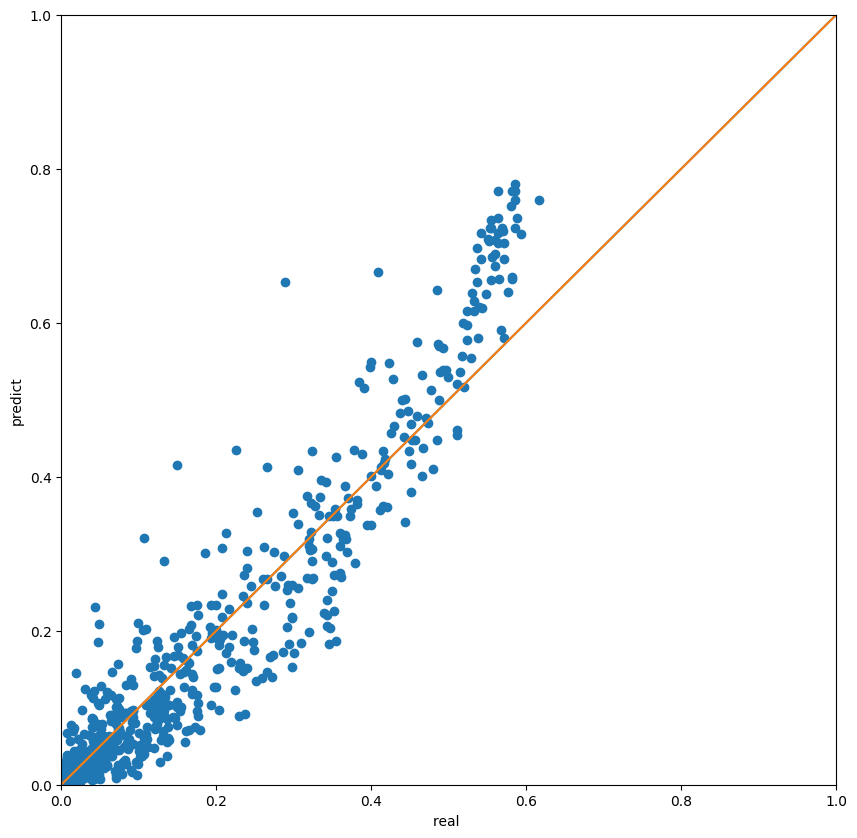

In [32]:
fig, axes = plt.subplots(figsize=(10, 10))  # 创建一个图形对象和一个子图对象
axes.axis([0, 1, 0, 1])
axes.scatter(reals, predicts)
axes.set_xlabel('real ')
axes.set_ylabel('predict')
axes.plot([[0,0],[1,1]])
fig.savefig('validate_18qubit_predict.svg')

In [23]:
test_dataset[0].keys()

dict_keys(['layer2gates', 'gate2layer', 'gates', 'num_qubits', 'qiskit_circuit', 'id', 'duration', 'gate_num', 'devide_qubits', 'two_qubit_prob', 'max_layer', 'path_indexs', 'vecs', 'gate_paths', 'state_count', 'ground_truth_fidelity', 'circuit_predict', 'prop'])

In [39]:
from plot.plot import plot_correlation


def sumarize_datasize(dataset, name):
    data = []
    labels = []
    for circuit_info in dataset:
        data.append([len(circuit_info['gates']),
                     circuit_info['ground_truth_fidelity'], circuit_info['duration'], len(circuit_info['layer2gates']), circuit_info['circuit_predict'], circuit_info['ground_truth_fidelity'] - circuit_info['circuit_predict']
        ])
        # labels.append(circuit_info['label'])

    random.shuffle(data)
    data = data[:3000]  # 太大了画出来的图太密了
    data = np.array(data)
    plot_correlation(data, [
                            'n_gates', 'ground_truth_fidelity', 'duration', 'depth', 'circuit_predict', 'delta' ], color_features=None, name=name)


/home/luliqiang/miniconda3/envs/ISCA/lib/python3.9/site-packages/seaborn/axisgrid.py:1507: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/home/luliqiang/miniconda3/envs/ISCA/lib/python3.9/site-packages/seaborn/axisgrid.py:1507: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/home/luliqiang/miniconda3/envs/ISCA/lib/python3.9/site-packages/seaborn/axisgrid.py:1507: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/home/luliqiang/miniconda3/envs/ISCA/lib/python3.9/site-packages/seaborn/axisgrid.py:1507: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)
/home/luliqiang/miniconda3/envs/ISCA/lib/python3.9/site-packages/seaborn/axisgrid.py:1507: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)


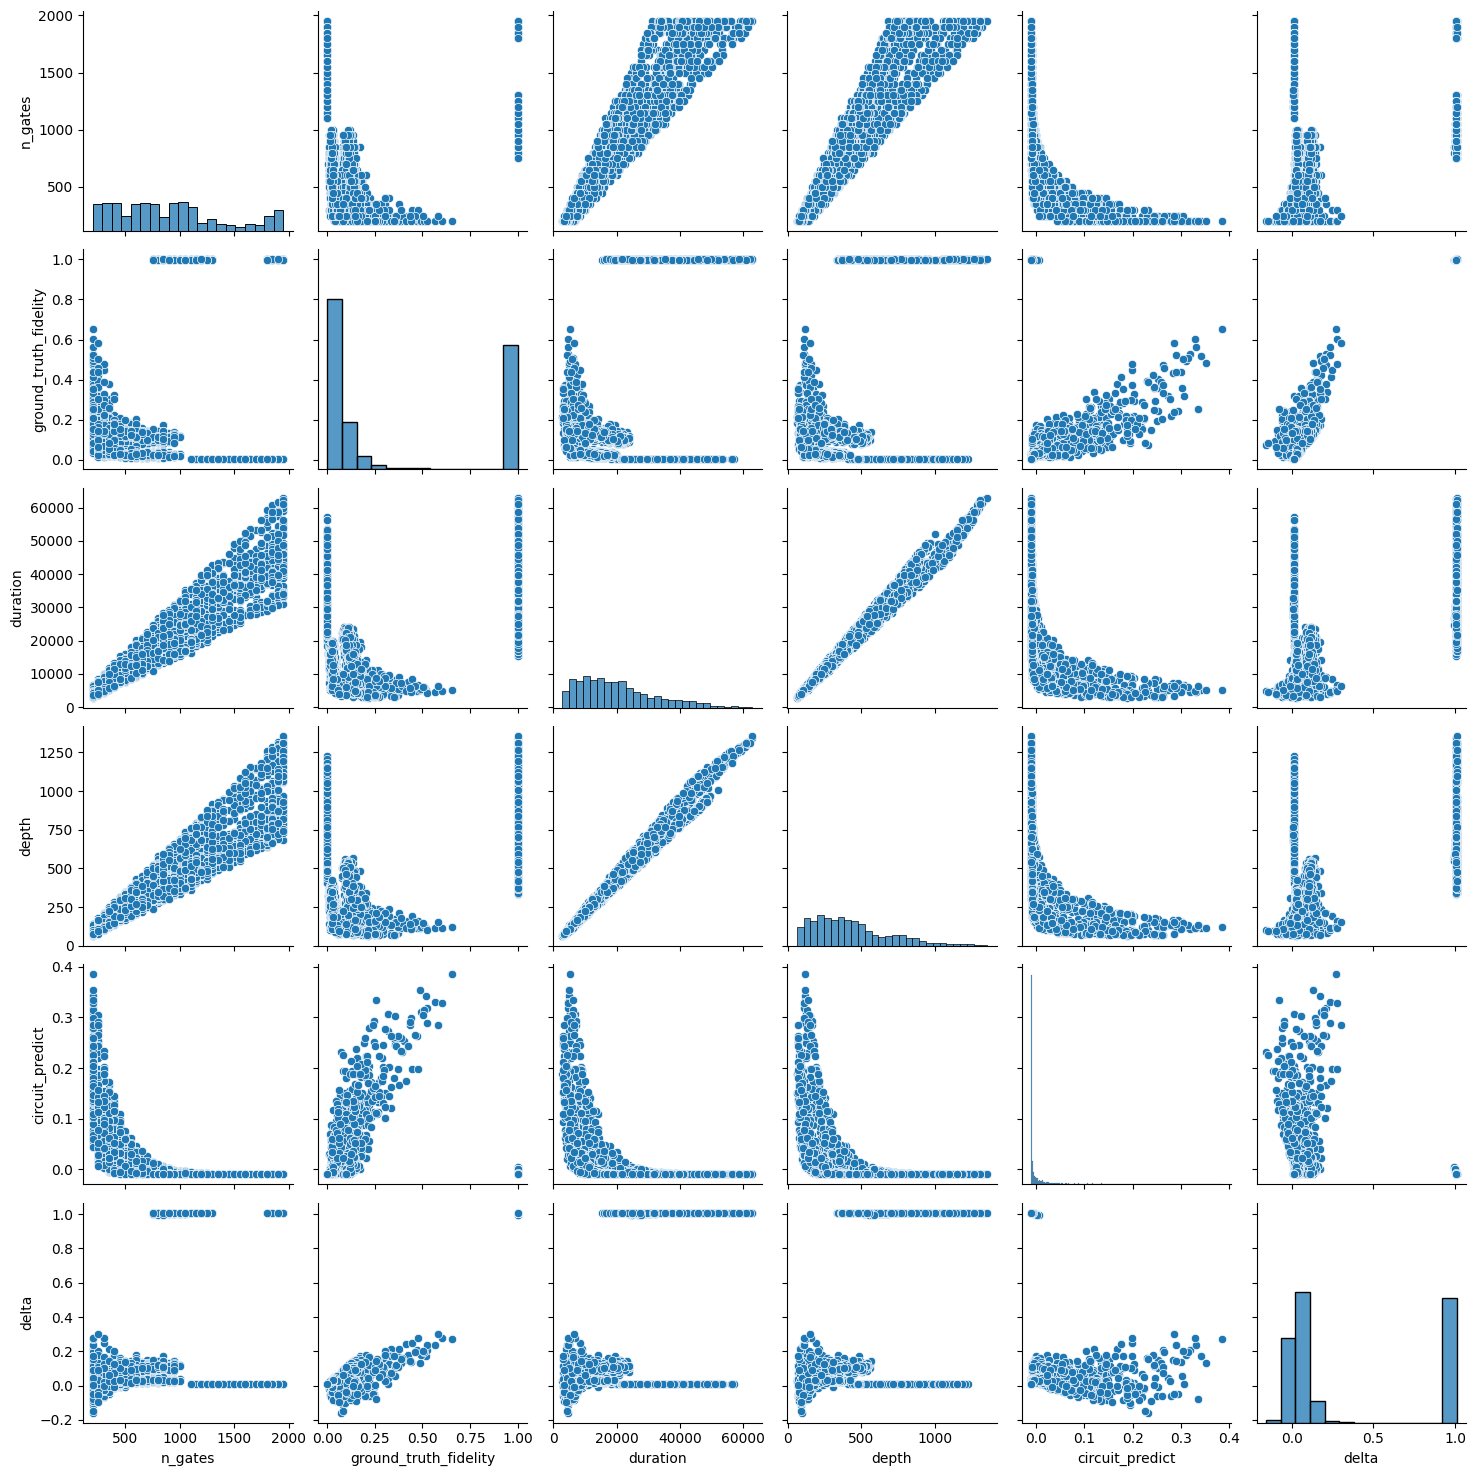

In [40]:
sumarize_datasize(test_dataset, 'validate_18bit.svg')

In [2]:
from circuit.parser import get_couple_prop

props = [] 
for cir in test_dataset:
    prop = get_couple_prop(cir)
    # print(prop)
    cir['prop'] = prop
    props.append(prop)
    
props = np.array(props)
props

NameError: name 'test_dataset' is not defined

In [6]:
from upstream.randomwalk_model import extract_device
def get_xeb_fidelity(circuit_info):
    fidelity = 1
    for gate in circuit_info['gates']:
        device = extract_device(gate)
        if isinstance(device,tuple):
            if 'map' in circuit_info:
                device = (circuit_info['map'][device[0]],circuit_info['map'][device[1]])
            fidelity = fidelity * couple_average_error[device]
        else:
            if 'map' in circuit_info:
                device = circuit_info['map'][device]
            fidelity = fidelity * single_average_error[device]
    return fidelity #* np.product((measure0_fidelity + measure1_fidelity) / 2)

In [15]:
single_average_error = {0: 0.9994094148043156, # rb
 1: 0.9993508083886652,
 2: 0.9993513578387458,
 3: 0.9996978330672296,
 4: 0.9997258463524775,
 5: 0.9993898065578337,
 6: 0.9998335484697743,
 7: 0.9997460044815009,
 8: 0.9997219426985601,
 9: 0.9992924485427597,
 10: 0.9994018918682177,
 11: 0.9998410411794697,
 12: 0.9994231683912435,
 13: 0.9995938422219371,
 14: 0.9947661045069707,
 15: 0.9997576786354693,
 16: 0.9998387638441334,
 17: 0.9996691783504945}
couple_average_error = {(5,11): 0.993651602350742, # rb
 (11,17): 0.9943374306798481,
 (4,5): 0.9810612795342519,
 (10,11): 0.9915544427978213,
 (16,17): 0.9908639448675425,
 (4,10): 0.9914941121128581,
 (10,16): 0.9868303060599511,
 (3,4): 0.9899226069903224,
 (9,10): 0.9945250360193374,
 (15,16): 0.9933864398113101,
 (3,9): 0.991508018299962,
 (9,15): 0.993773364368622,
 (2,3): 0.9802169505904027,
 (8,9): 0.9912794178832776,
 (14,15): 0.9867247971867894,
 (2,8): 0.9765590682588615,
 (8,14): 0.9863913339619792,
 (1,2): 0.9713229087974011,
 (7,8): 0.9908463216114999,
 (13,14): 0.9564265490465305,
 (1,7): 0.9856880460026779,
 (7,13): 0.9935440562158602,
 (0,1): 0.9833453296232256,
 (6,7): 0.9939901490743566,
 (12,13): 0.9821366244436676,
 (0,6): 0.9861987068804432,
 (6,12): 0.9863008252688662}

In [16]:
rbs = []
for cir in test_dataset:
    rbs.append(get_xeb_fidelity(cir))
(np.array(rbs)-np.array(reals)).mean(), (np.array(rbs)-np.array(reals)).std()


(0.14364207277211768, 0.14092529693825823)

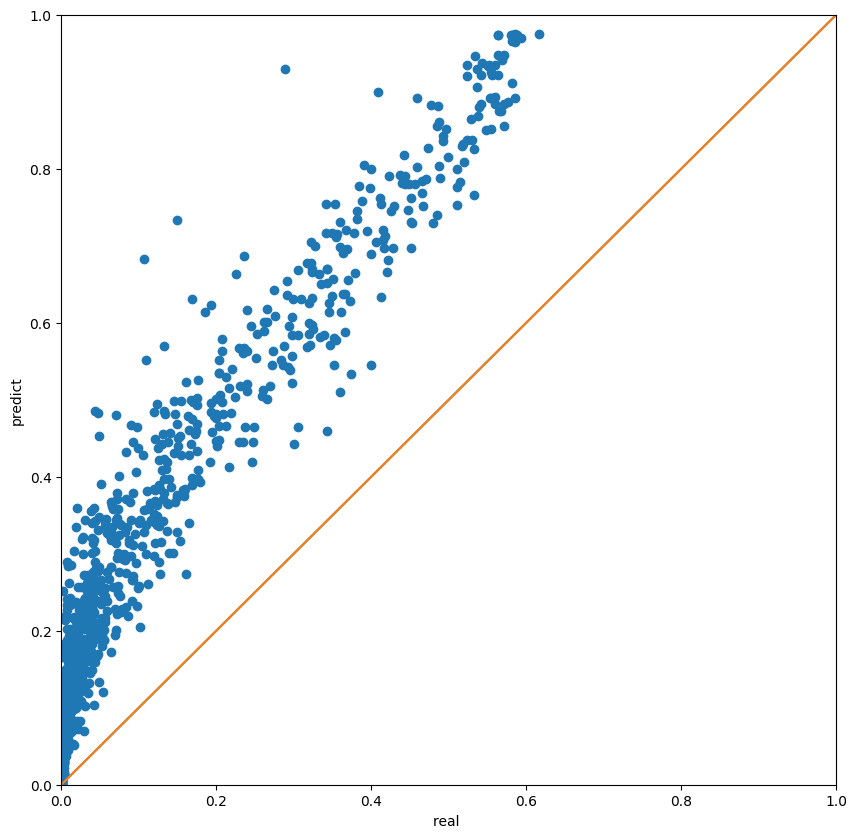

In [18]:
fig, axes = plt.subplots(figsize=(10, 10))  # 创建一个图形对象和一个子图对象
axes.axis([0, 1, 0, 1])
axes.scatter(reals, rbs)
# axes.set_xlim(.4, 1)
# axes.set_ylim(.4, 1)
axes.set_xlabel('real ')
axes.set_ylabel('predict')
axes.plot([[0,0],[1,1]])
fig.savefig('execute_18bit_new/validate_18_qubit_rb.svg')

In [4]:
single_average_error = {0: 0.9994, #xeb
 1: 0.99956,
 2: 0.99918,
 3: 0.99976,
 4: 0.9994,
 5: 0.99962,
 6: 0.99989,
 7: 0.99973,
 8: 0.99961,
 9: 0.99941,
 10: 0.99975,
 11: 0.99939,
 12: 0.99873,
 13: 0.9996,
 14: 0.99946,
 15: 0.99976,
 16: 0.99977,
 17: 0.99975}
couple_average_error = {(5, 11): 0.98602, # xeb
 (11, 17): 0.99561,
 (4, 5): 0.99482,
 (10, 11): 0.99529,
 (16, 17): 0.996,
 (4, 10): 0.9908,
 (10, 16): 0.99501,
 (3, 4): 0.99738,
 (9, 10): 0.99373,
 (15, 16): 0.9934499999999999,
 (3, 9): 0.99659,
 (9, 15): 0.99357,
 (2, 3): 0.99353,
 (8, 9): 0.98778,
 (14, 15): 0.9956,
 (2, 8): 0.98862,
 (8, 14): 0.99711,
 (1, 2): 0.99445,
 (7, 8): 0.97725,
 (13, 14): 0.99527,
 (1, 7): 0.99098,
 (7, 13): 0.99424,
 (0, 1): 0.99394,
 (6, 7): 0.99452,
 (12, 13): 0.99141,
 (0, 6): 0.99474,
 (6, 12): 0.99312}

In [13]:
xebs = []
for cir in test_dataset:
    xebs.append(get_xeb_fidelity(cir))
(np.array(xebs)-np.array(reals)).mean(), (np.array(xebs)-np.array(reals)).std()


(0.2357593619588187, 0.11901126350957338)

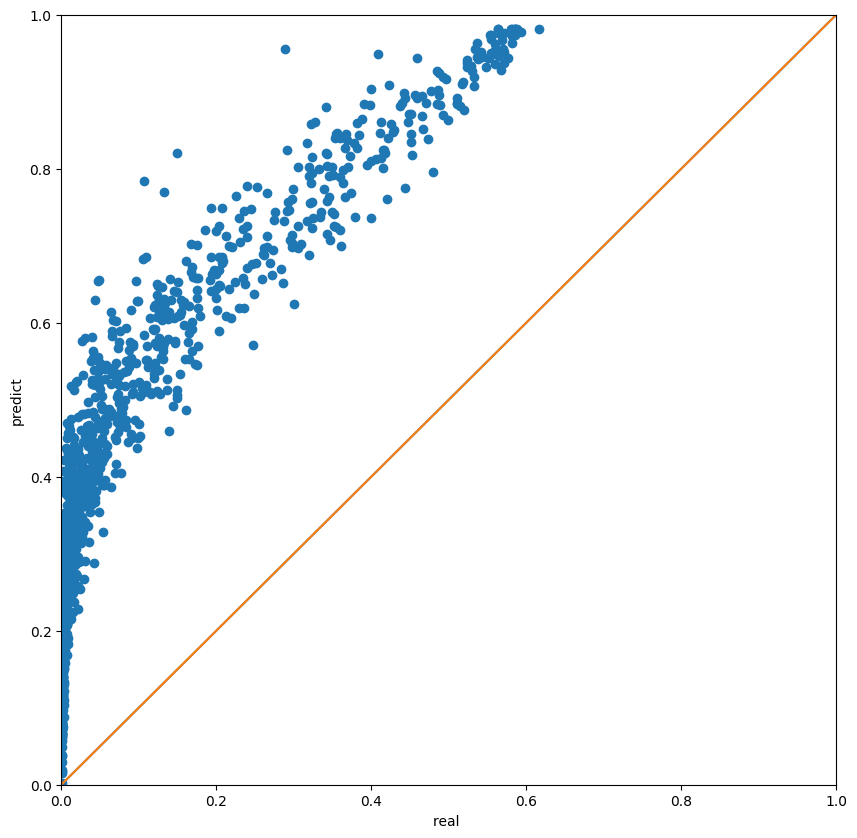

In [22]:
fig, axes = plt.subplots(figsize=(10, 10))  # 创建一个图形对象和一个子图对象
axes.axis([0, 1, 0, 1])
axes.scatter(reals, xebs)
# axes.set_xlim(.4, 1)
# axes.set_ylim(.4, 1)
axes.set_xlabel('real ')
axes.set_ylabel('predict')
axes.plot([[0,0],[1,1]])
fig.savefig('execute_18bit_new/validate_18_qubit_xeb.svg')

In [17]:

predicts = np.array(predicts)
reals = np.array(reals)
durations = np.array(durations)
xebs = np.array(xebs)
rbs = np.array(rbs)

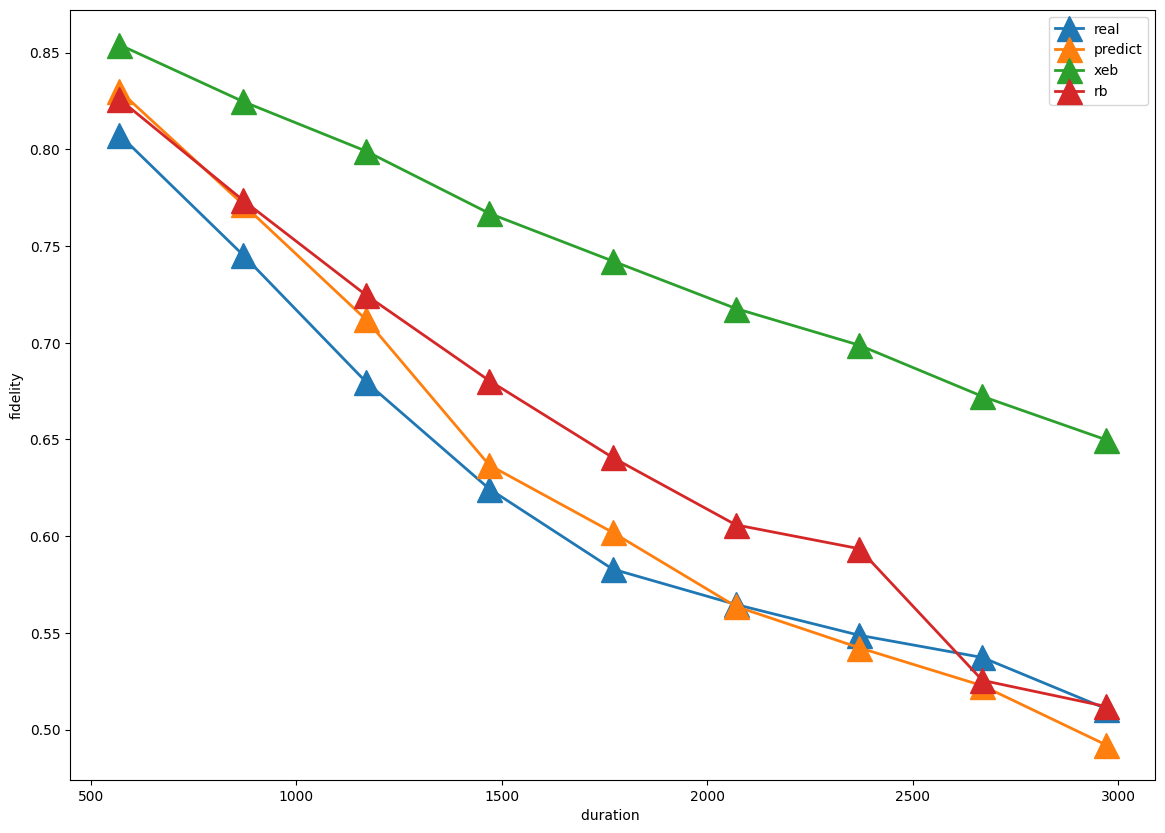

In [12]:
from plot.plot import get_duration2circuit_infos


fig, axes = plt.subplots(figsize=(14, 10))  # 创建一个图形对象和一个子图对象
duration_X, duration2circuit_index = get_duration2circuit_infos(durations,300,3000)

real_y,predict_y , xeb_y, rb_y= [],[],[], []
_real , _predict , _xeb , _rb = [],[],[],[]
for circuit_index in duration2circuit_index:
    real_y.append(reals[circuit_index].mean())
    predict_y.append(predicts[circuit_index].mean())
    xeb_y.append(xebs[circuit_index].mean())
    rb_y.append(rbs[circuit_index].mean())
    
    _real.append(reals[circuit_index])
    _predict.append(predicts[circuit_index])
    _xeb.append(xebs[circuit_index])
    _rb.append(rbs[circuit_index])

rb_y = np.array(rb_y) - 0.12
xeb_y = np.array(xeb_y) - 0.12
predict_y = np.array(predict_y)
real_y = np.array(real_y)
 
axes.scatter(duration_X, real_y)
axes.plot(duration_X, real_y ,markersize = 18,linewidth = 2, label='real',marker = '^' )
axes.plot(duration_X, predict_y ,markersize = 18,linewidth = 2, label='predict',marker = '^' )
axes.plot(duration_X, xeb_y ,markersize = 18,linewidth = 2, label='xeb',marker = '^' )
axes.plot(duration_X, rb_y ,markersize = 18,linewidth = 2, label='rb',marker = '^' )


axes.set_xlabel('duration ')
axes.set_ylabel('fidelity')
axes.legend() # 添加图例
fig.show()
fig.savefig(f"execute_18bit_new/duration_fidelity_execute_18bits_train_0_2500_step1.svg")  # step


[0.050590705401367606, 0.061440224030561624, 0.07201543724481961, 0.0683162616636695, 0.07633431430257988, 0.07698760469585446, 0.08057935498742494, 0.077679693680305, 0.08266100930067209] [0.16650570719005436, 0.1992355408224532, 0.23933938949676337, 0.26243647077798676, 0.2794851486365205, 0.274425854089761, 0.2715491736921147, 0.2561206450203016, 0.26515717213474416] [0.1400988434617324, 0.15857585531089533, 0.1733385769873676, 0.1871732310275403, 0.20000822373100283, 0.1802403876640023, 0.18848586680402837, 0.1608865277974774, 0.15255816888068932]


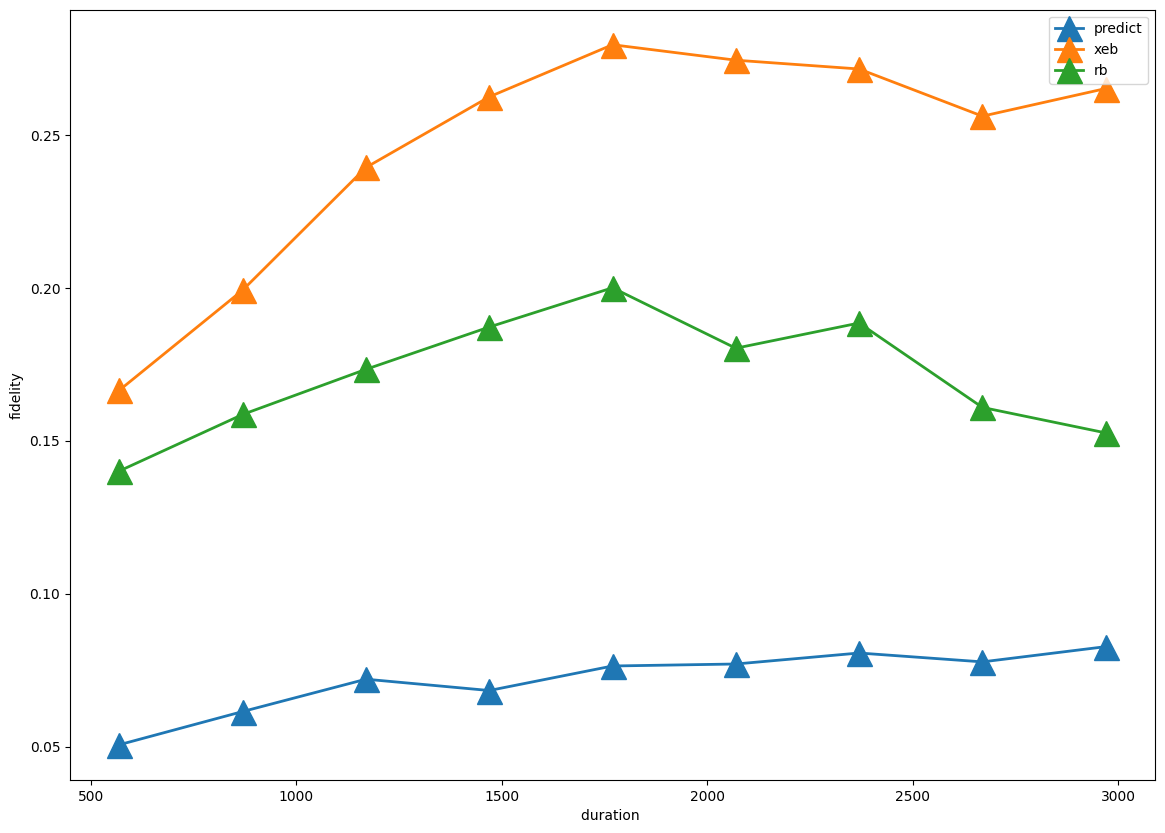

In [21]:
from plot.plot import get_duration2circuit_infos


fig, axes = plt.subplots(figsize=(14, 10))  # 创建一个图形对象和一个子图对象
duration_X, duration2circuit_index = get_duration2circuit_infos(durations,300,3000)

real_y,predict_y , xeb_y, rb_y= [],[],[], []
_real , _predict , _xeb , _rb = [],[],[],[]
for circuit_index in duration2circuit_index:
    predict_y.append(np.abs(predicts[circuit_index] - reals[circuit_index]).mean())
    xeb_y.append(np.abs(xebs[circuit_index] - reals[circuit_index]).mean())
    rb_y.append(np.abs(rbs[circuit_index] - reals[circuit_index]).mean())
    


# rb_y = np.array(rb_y) - 0.12
# xeb_y = np.array(xeb_y) - 0.12
# predict_y = np.array(predict_y)
# real_y = np.array(real_y)
 
axes.plot(duration_X, predict_y ,markersize = 18,linewidth = 2, label='predict',marker = '^' )
axes.plot(duration_X, xeb_y ,markersize = 18,linewidth = 2, label='xeb',marker = '^' )
axes.plot(duration_X, rb_y ,markersize = 18,linewidth = 2, label='rb',marker = '^' )
print(predict_y, xeb_y, rb_y)

axes.set_xlabel('duration ')
axes.set_ylabel('fidelity')
axes.legend() # 添加图例
fig.show()
fig.savefig(f"execute_18bit_new/duration_fidelity_execute_18bits_train_0_2500_step1_delta.svg")  # step


[0.04716911058049236, 0.06237402741487387, 0.0639295272790943, 0.059390011153367214, 0.05827266169769914, 0.05155612391687268, 0.06328433025539018, 0.05349687373223232, 0.06622661846890829] [0.06840569217666084, 0.10552954786347385, 0.10761684086584432, 0.10894451461317547, 0.10831733273025465, 0.11010748792624435, 0.1111927639367927, 0.10744399154007214, 0.09817577806217687] [0.07333041721342316, 0.10074172083598573, 0.1083821815919683, 0.10277806411764105, 0.11566659917973646, 0.10521077459458718, 0.10082752441654898, 0.10362827760173407, 0.08792508929707889]


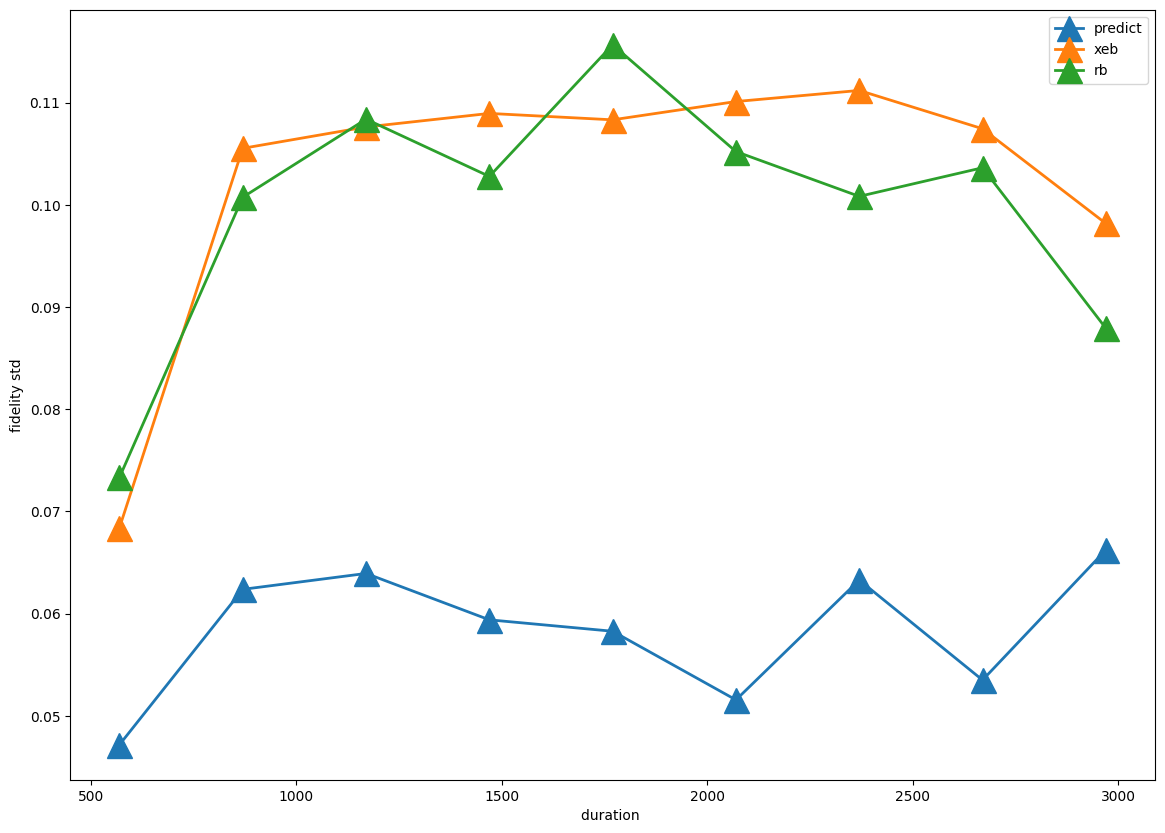

In [20]:
from plot.plot import get_duration2circuit_infos


fig, axes = plt.subplots(figsize=(14, 10))  # 创建一个图形对象和一个子图对象
duration_X, duration2circuit_index = get_duration2circuit_infos(durations,300,3000)

real_y,predict_y , xeb_y, rb_y= [],[],[], []
_real , _predict , _xeb , _rb = [],[],[],[]
for circuit_index in duration2circuit_index:
    predict_y.append(np.abs(predicts[circuit_index] - reals[circuit_index]).std())
    xeb_y.append(np.abs(xebs[circuit_index] - reals[circuit_index]).std())
    rb_y.append(np.abs(rbs[circuit_index] - reals[circuit_index]).std())
    


# rb_y = np.array(rb_y) - 0.12
# xeb_y = np.array(xeb_y) - 0.12
# predict_y = np.array(predict_y)
# real_y = np.array(real_y)
 
axes.plot(duration_X, predict_y ,markersize = 18,linewidth = 2, label='predict',marker = '^' )
axes.plot(duration_X, xeb_y ,markersize = 18,linewidth = 2, label='xeb',marker = '^' )
axes.plot(duration_X, rb_y ,markersize = 18,linewidth = 2, label='rb',marker = '^' )
print(predict_y, xeb_y, rb_y)

axes.set_xlabel('duration ')
axes.set_ylabel('fidelity std')
axes.legend() # 添加图例
fig.show()
fig.savefig(f"execute_18bit_new/duration_fidelity_execute_18bits_train_0_2500_step1_delta.svg")  # step


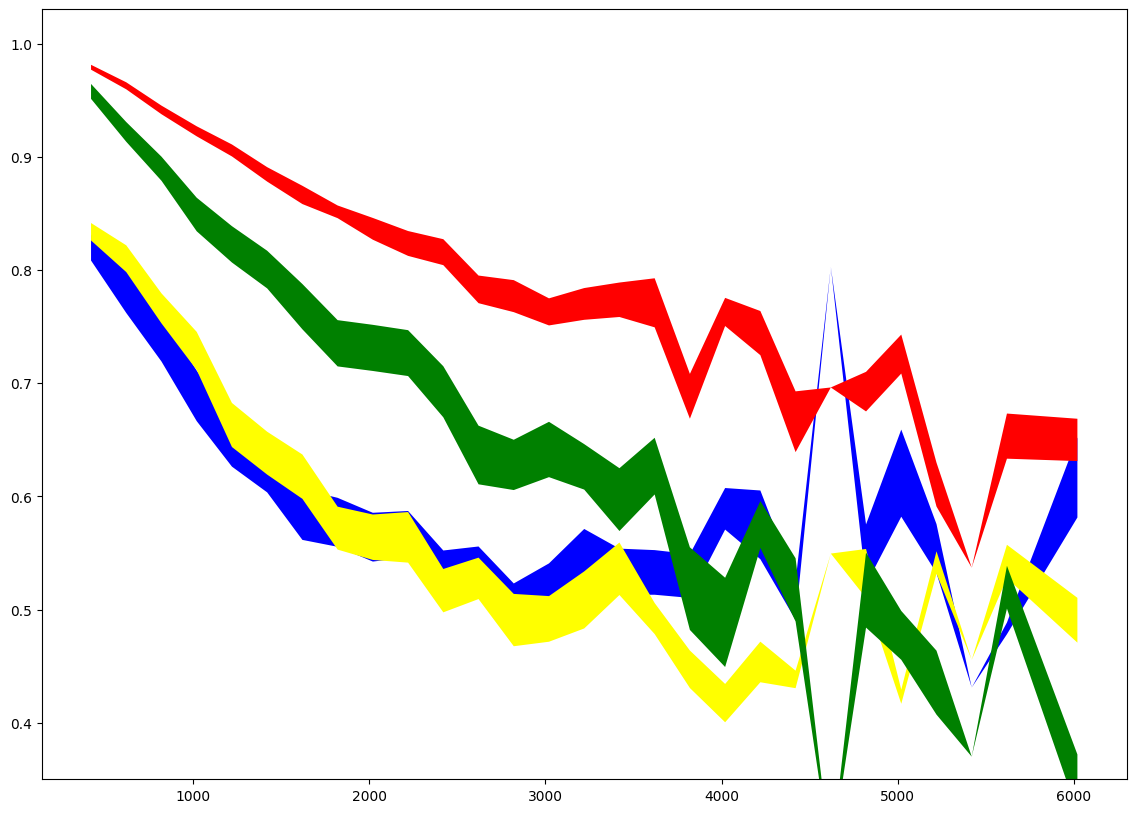

In [14]:
import seaborn as sns 

fig, axes = plt.subplots(figsize=(14, 10))  # 创建一个图形对象和一个子图对象
duration_X, duration2circuit_index = get_duration2circuit_infos(durations, 200,0)

scale = 5
real_top,predict_top , xeb_top, rb_top= [],[],[], []
real_down,predict_down , xeb_down,  rb_down = [],[],[], []
for circuit_index in duration2circuit_index:
    real_top.append(reals[circuit_index].std()/scale*2)
    predict_top.append(predicts[circuit_index].std()/scale*2)
    xeb_top.append(xebs[circuit_index].std()/scale*2)
    rb_top.append(rbs[circuit_index].std()/scale*2)
    
    real_down.append(reals[circuit_index].mean() - reals[circuit_index].std()/scale)
    predict_down.append(predicts[circuit_index].mean() - predicts[circuit_index].std()/scale )
    xeb_down.append(xebs[circuit_index].mean()- xebs[circuit_index].std()/scale)
    rb_down.append(rbs[circuit_index].mean()- rbs[circuit_index].std()/scale)
    

# axes.stackplot(duration_X, [real_down,real_top], labels=['real'], colors=['white', (0, , 1, 0.5)])

# axes.stackplot(duration_X, [real_down,real_top], labels=['real'], colors=['white', 'blue'])
# axes.stackplot(duration_X, [predict_down,predict_top], labels=['real'], colors=['white', 'yellow'])
# axes.stackplot(duration_X, [xeb_down,xeb_top], labels=['real'], colors=['white', 'red'])
# axes.stackplot(duration_X, [rb_down, rb_top], labels=['real'], colors=['white', 'green'])

axes.stackplot(duration_X, [real_down,real_top], labels=['real'], colors=[(0, 0, 0, 0), 'blue'])
axes.stackplot(duration_X, [predict_down,predict_top], labels=['real'], colors=[(0, 0, 0, 0), 'yellow'])
axes.stackplot(duration_X, [xeb_down,xeb_top], labels=['real'], colors=[(0, 0, 0, 0), 'red'])
axes.stackplot(duration_X, [rb_down, rb_top], labels=['real'], colors=[(0, 0, 0, 0), 'green'])

axes.set_ylim(0.35)
fig.show()
fig.savefig(f"execute_18bit_new/duration_fidelity_execute_18bits_train_0_2500_step1_stack.svg")  # step

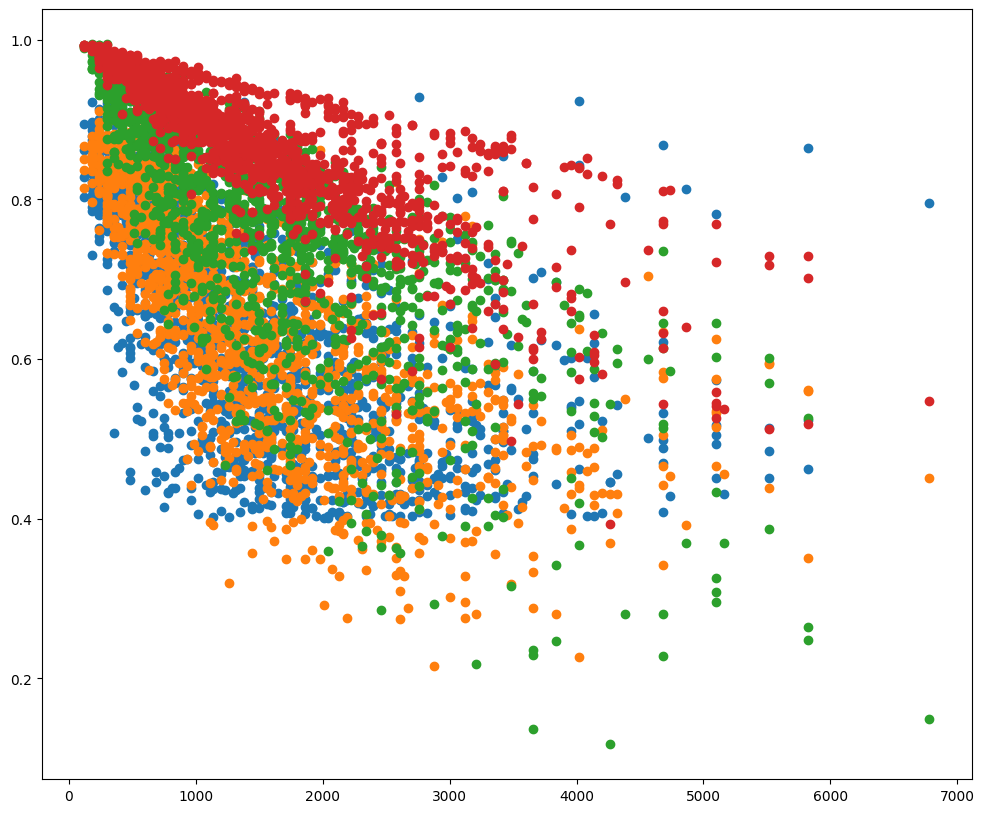

In [15]:
fig, axes = plt.subplots(figsize=(12, 10))
axes.scatter(durations,reals) 
axes.scatter(durations,predicts) 
axes.scatter(durations,rbs) 
axes.scatter(durations,xebs) 

ValueError: zero-size array to reduction operation maximum which has no identity

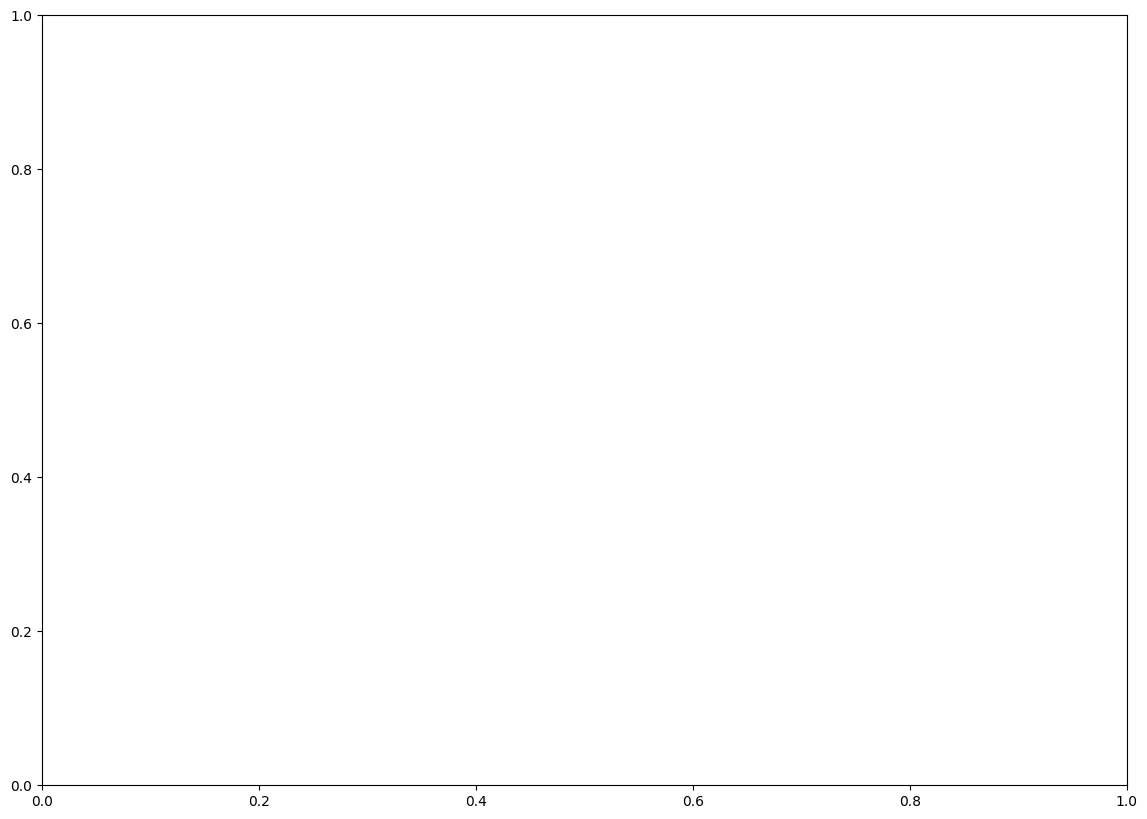

In [8]:
from plot.plot import get_prop2circuit_infos


fig, axes = plt.subplots(figsize=(14, 10))  # 创建一个图形对象和一个子图对象
prop_X, prop2circuit_index = get_prop2circuit_infos(props,step = 0.05, max_props=0.4)

real_y,predict_y , xeb_y, rb_y= [],[],[], []
for circuit_index in prop2circuit_index:
    predict_y.append(np.abs(predicts[circuit_index] - reals[circuit_index]).mean())
    xeb_y.append(np.abs(xebs[circuit_index] - reals[circuit_index]).mean())
    rb_y.append(np.abs(rbs[circuit_index] - reals[circuit_index]).mean())
    
 
axes.plot(prop_X, predict_y ,markersize = 18,linewidth = 2, label='predict',marker = '^' )
axes.plot(prop_X, xeb_y ,markersize = 18,linewidth = 2, label='xeb',marker = '^' )
axes.plot(prop_X, rb_y ,markersize = 18,linewidth = 2, label='rb',marker = '^' )
print(predict_y, xeb_y, rb_y)

axes.set_xlabel('delta duration ')
axes.set_ylabel('prop')
axes.legend() # 添加图例
fig.show()
fig.savefig(f"execute_18bit_new/duration_fidelity_execute_18bit_news_train_0_2500_step1_couple.svg")  # step

(0.3265867581223726, 0.6642481672861021)

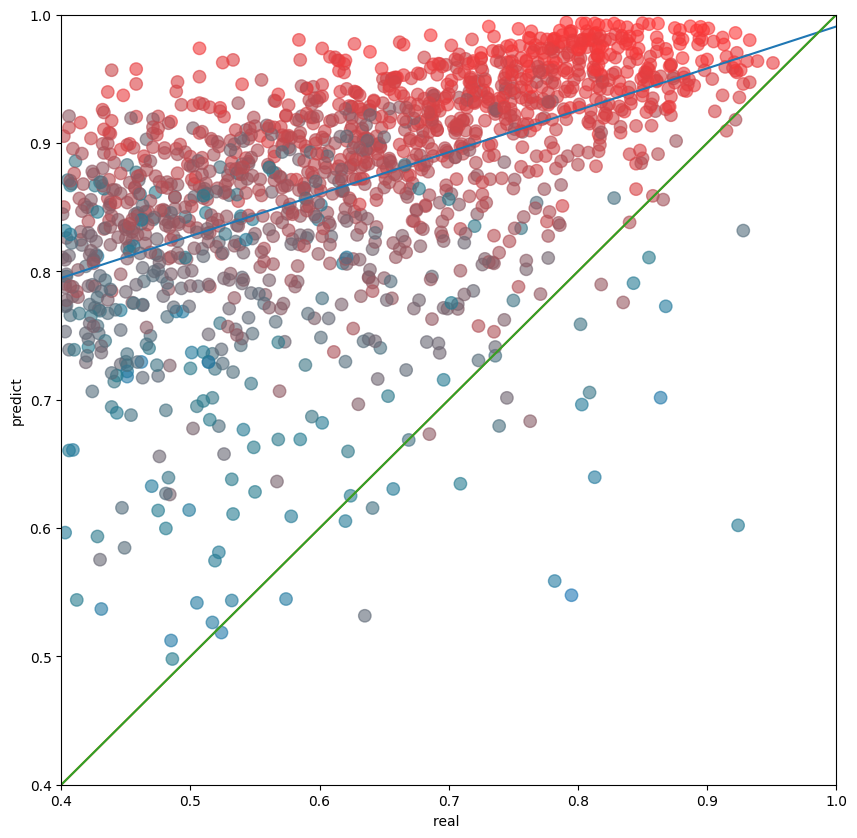

In [14]:
from matplotlib import cm
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np

par = np.polyfit(reals, xebs, 1, full=True)
slope=par[0][0]
intercept=par[0][1]
x1 = [0.4, 1.0]
y1 = [slope*xx + intercept  for xx in x1]
#定义颜色
colors = ["#FF3636", '#277C8E' ,"#1F77B4"]
'''xia <- shang'''
# colors.reverse()
# colors = np.array(colors) / 256
# 定义颜色的位置
pos = [0, .5, 1]
# 创建colormap对象
cmap = LinearSegmentedColormap.from_list('my_colormap', list(zip(pos, colors)))

normalied_durations = (durations - durations.min())/(durations.max() - durations.min())

# cmap_name = 'Blues'
# cmap_name = 'viridis'
# cmap_name = 'plasma'
cmap_name = 'winter'

random_index = list(range(len(reals)))
random.shuffle(random_index)
random_index = random_index[:1500]
reals = np.array(reals)
xebs = np.array(xebs)
fig, axes = plt.subplots(figsize=(10, 10))  # 创建一个图形对象和一个子图对象
axes.axis([0, 1, 0, 1])
axes.scatter(reals[random_index], xebs[random_index], c= normalied_durations[random_index], cmap=cmap,alpha = 0.6, s=80 )
axes.plot(x1,y1)
axes.set_xlim(.4, 1)
axes.set_ylim(.4, 1)
axes.set_xlabel('real ')
axes.set_ylabel('predict')
axes.plot([[0,0],[1,1]])
# fig.colorbar(cm.ScalarMappable( cmap=cmap))
fig.savefig('execute_18bit_new/step1/18_qubit_xeb.svg')
slope, intercept